In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 500) # To display all the columns of dataframe
pd.set_option('max_colwidth', None) # To set the width of the column to maximum
import warnings # To ignore warnings
warnings.filterwarnings("ignore")
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

In [7]:
sns.set_theme()

In [ ]:
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**PassengerId**

The first column is the passenger ID. The ID for a passenger is just number to identify this passenger in this dataset. So this column is not really a part of the information we should care about. We can drop this column or make it the index for this dataset. Let's make it the index for the dataset just to demonstrate the use of `df.set_index` method

In [11]:
if "PassengerId" in df_train.columns:
    df_train.set_index(df_train.PassengerId, inplace=True)
    df_train.drop("PassengerId", axis=1, inplace=True)
else:
    pass

In [12]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
df_test.set_index(df_test.PassengerId, inplace=True)
df_test.drop("PassengerId", axis=1, inplace=True)

In [14]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 1. Feature Classification: Categorical vs Numerical

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [122]:
def cal_ChiSquare(feature, df = df_train):
    crosstab = pd.crosstab(df["Survived"], df[feature])
    chi2, p, dof, expected = chi2_contingency(crosstab)

    print(f"\nChi-Square Test for {feature}:")
    print(f"Chi2 statistic: {chi2:.3f}")
    print(f"Degrees of freedoom: {dof}")
    print(f"p - value: {p}")
    if p <= 0.05:
        print(f"🟢 Survived depends on {feature}")
    else:
        print(f"⚪ Survived does not depend on {feature}")

# H0: The feature follows normal distribution.
# Ha: The feature does not follow normal distribution.
# https://www.statskingdom.com/shapiro-wilk-test-calculator.html
def cal_shapiro(feature_cat, feature_num, df = df_train):
    # Use statistical test to check.
    for item in df[feature_cat].unique():
        stat, p = shapiro(df[df[feature_cat] == item][feature_num])
        print(f"Shapiro-Wilk statistic: {stat:.3f}")
        print(f"p - value: {p}")
        if p > 0.05:
            print(f"🟢 {feature_num} ({feature_cat} {item}) follows normal distribution.")
            print("*" * 80)
        else:
            # The data allows you to reject the null hypothesis (H0)
            print(f"⚪ {feature_num} ({feature_cat} {item}) does not follow normal distribution.")
            print("*" * 80)

#The features belonging to the numerical feature in the dataset does not follow the normal distribution so the T-Test cannot be used.
# Research hypothesis: There is a difference in "feature" between the group of attrition employees and the group of working employees.
# Statistical hypothesis test (H0)
# H0: There is no significant difference in "feature" between the two groups.
# Ha: There is a significant difference in "feature" between the group of attrition employees and the group of working employees.
# https://library.virginia.edu/data/articles/the-wilcoxon-rank-sum-test
def cal_Wilcoxon(feature_cat, feature_num, df = df_train):
    group_yes = df[df[feature_cat] == 1][feature_num]
    group_no = df[df[feature_cat] == 0][feature_num]

    stat, p = mannwhitneyu(group_yes, group_no, alternative='two-sided')

    print(f"Wilcoxon rank-sum test (Mann-Whitney U statistic): {stat:.3f}")
    print(f"p-value: {p}")
    if p <= 0.05:
        # The data allows you to reject the null hypothesis (H0)
        print("🟢 There is a significant difference between the two groups.")
    else:
        print("⚪ There is no significant difference between the two groups.")

In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


* Categorical: `Survived`, `Sex`, `Embarked`, `Pclass` (ordinal), `SibSp`, `Parch`.
* Numerical: (Continuous)`Age`, `Fare`(discrete).
* Mix type of data: `Ticket`, `Cabin`.
* Contain Error/Typo: `Name`.
* Blank or Null: `Cabin` > `Age` > `Embarked`.
* Varous data type: `string`, `int`, `float`.

In [18]:
cat_features = ["Survived", "Sex", "Embarked", "Pclass", "SibSp", "Parch"]
def convert_cat(df, cat_features = cat_features):
    for feature in cat_features:
        if feature in df.columns:
            df[feature] = df[feature].astype("category")
        else:
            pass
convert_cat(df_train)
convert_cat(df_test)

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    category
 1   Pclass    891 non-null    category
 2   Name      891 non-null    object  
 3   Sex       891 non-null    category
 4   Age       714 non-null    float64 
 5   SibSp     891 non-null    category
 6   Parch     891 non-null    category
 7   Ticket    891 non-null    object  
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    object  
 10  Embarked  889 non-null    category
dtypes: category(6), float64(2), object(3)
memory usage: 48.2+ KB


In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    418 non-null    category
 1   Name      418 non-null    object  
 2   Sex       418 non-null    category
 3   Age       332 non-null    float64 
 4   SibSp     418 non-null    category
 5   Parch     418 non-null    category
 6   Ticket    418 non-null    object  
 7   Fare      417 non-null    float64 
 8   Cabin     91 non-null     object  
 9   Embarked  418 non-null    category
dtypes: category(5), float64(2), object(3)
memory usage: 22.7+ KB


### 1.1. Distribution of numerical feature values across the samples

In [21]:
num_features = ["Age", "Fare"]
df_train.describe()

,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


**Observation:** <br>
* There are `714` values ​​in the dataset, the Age column has a missing value.
* The average age of passengers boarding the train is nearly `30 years old`. The smallest is `0.42` (newborn), the largest is `80` years old.
* The average fare is `32.2$`, the smallest is `0$`, the largest is `512.3$`

### 1.2. Distribution of categorical feature values across the samples

In [22]:
df_train.describe(include=["category"])

,Survived,Pclass,Sex,SibSp,Parch,Embarked
count,891,891,891,891,891,889
unique,2,3,2,7,7,3
top,0,3,male,0,0,S
freq,549,491,577,608,678,644


**Observation:** <br>
* **Survived:** There are 2 types 0 (dead), 1 (alive) and there are `549` dead people out of `891` people.
* **Pclass:** There are 3 types of tickets, type 3 tickets are the most popular with `491` tickets out of `891` tickets.
* **Sex:** Men are more popular than women with `577` people.
* **SibSp:** There are `608` people who do not bring friends, wives, etc.
* **Parch:** There are `678` people who do not bring parents, children, etc.
* **Embarked:** There are `644` people departing from port S (Southampton).

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
## 2. Exploratory Data Analysis (EDA)
### 2.1. Correlating categorical feature
* Categorical: `Sex`, `Embarked`, `Pclass` (ordinal), `SibSp`, `Parch`.

**Target Variable**: `Survived`

In [23]:
df_train["Survived"].value_counts().to_frame()

,count
Survived,
0,549
1,342


In [24]:
df_train["Survived"].value_counts(normalize=True).to_frame()

,proportion
Survived,
0,0.616162
1,0.383838


🟢 Only `38%` survived the disaster. So the training data is suffers from data imbalance but it is not severe, which is why I will not consider techniques like sampling to tackle the imbalance.
#### 2.1.1. Sex

In [25]:
df_train["Sex"].value_counts().to_frame()

,count
Sex,
male,577
female,314


In [26]:
df_train.groupby("Sex")["Survived"]

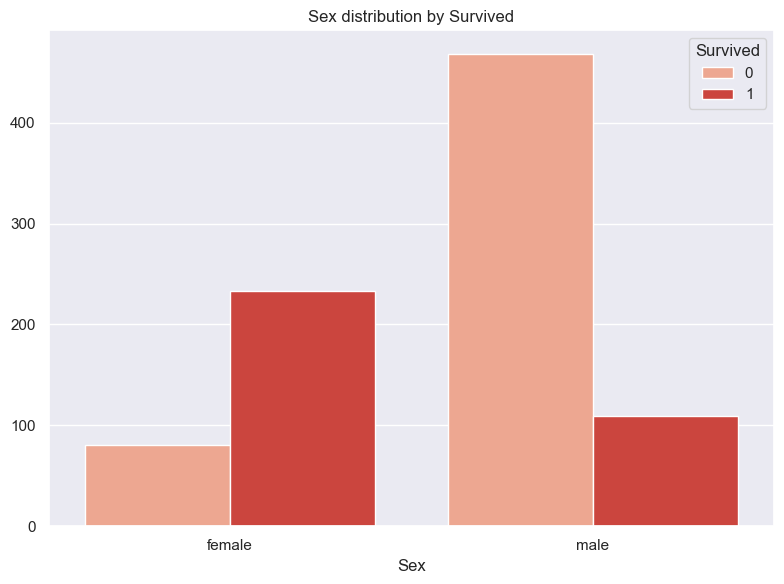


Chi-Square Test for Sex:
Chi2 statistic: 260.717
Degrees of freedoom: 1
p - value: 1.1973570627755645e-58
🔴 Survived depends on Sex


In [27]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_train, x = "Sex", hue="Survived", palette="Reds");
plt.title("Sex distribution by Survived")
plt.xlabel('Sex')
plt.ylabel('')
plt.tight_layout()
plt.show()

cal_ChiSquare("Sex")

🟢 For females, the number of survivors is twice as high as that of males. <br>
=> This shows that in the event of an accident, women are given priority over men, so the survival rate of women is higher.

#### 2.1.2. Remaining categorical feature columns

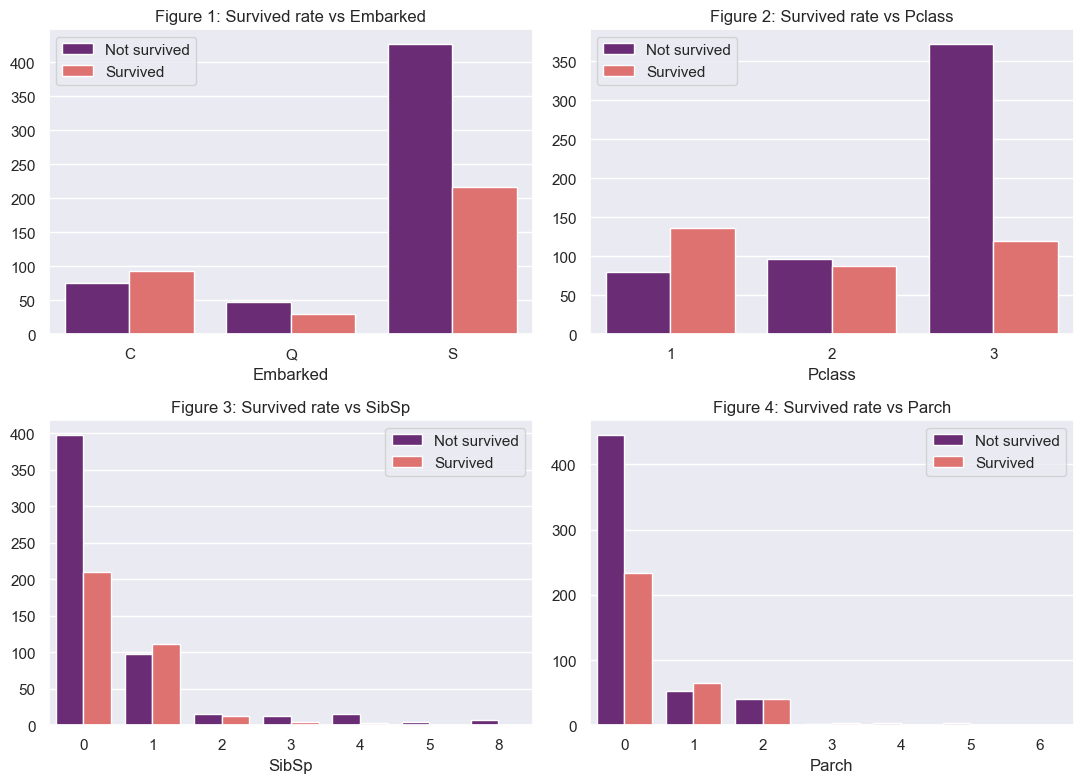


Chi-Square Test for Embarked:
Chi2 statistic: 26.489
Degrees of freedoom: 2
p - value: 1.769922284120912e-06
🟢 Survived depends on Embarked

Chi-Square Test for Pclass:
Chi2 statistic: 102.889
Degrees of freedoom: 2
p - value: 4.549251711298793e-23
🟢 Survived depends on Pclass

Chi-Square Test for SibSp:
Chi2 statistic: 37.272
Degrees of freedoom: 6
p - value: 1.5585810465902118e-06
🟢 Survived depends on SibSp

Chi-Square Test for Parch:
Chi2 statistic: 27.926
Degrees of freedoom: 6
p - value: 9.703526421039996e-05
🟢 Survived depends on Parch


In [40]:
cols = ["Embarked", "Pclass", "SibSp", "Parch"]
n_rows = 2
n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize = (n_cols * 5.5, n_rows * 4))

for r in range(0, n_rows):
    for c in range(0, n_cols):
        i = r * n_cols + c # index to loop through list "cols"
        if i < len(cols):
            ax_i = ax[r, c]
            sns.countplot(data=df_train, x = cols[i], palette="magma", hue="Survived", ax=ax_i);
            ax_i.set_title(f"Figure {i + 1}: Survived rate vs {cols[i]}")
            if r == 0:
                ax_i.legend(title = '', loc= "upper left", labels = ["Not survived", "Survived"])
            else:
                ax_i.legend(title = '', loc= "upper right", labels = ["Not survived", "Survived"])
            ax_i.set_ylabel("")
        else:
            pass

plt.tight_layout()
plt.show()

for col in cols:
    cal_ChiSquare(col)

**Observation:** <br>
* Survival rate: <br>
🟢 Fig 1: Most people embarked on Southampton, and also had the highest people not survived. <br>
🟢 Fig 2: 1st class higher survival rate. <br>
🟢 Fig 3: People going with 0 `SibSp` are mostly not survived, the number of passenger with 1 - 2 family members has a better chance of survival. <br>
🟢 Fig 4: People going with 0 `Parch` are mostly not survived.

### 2.2 EDA for numerical feature
* Numerical features: `Age`, `Fare`

#### 2.2.1. Age

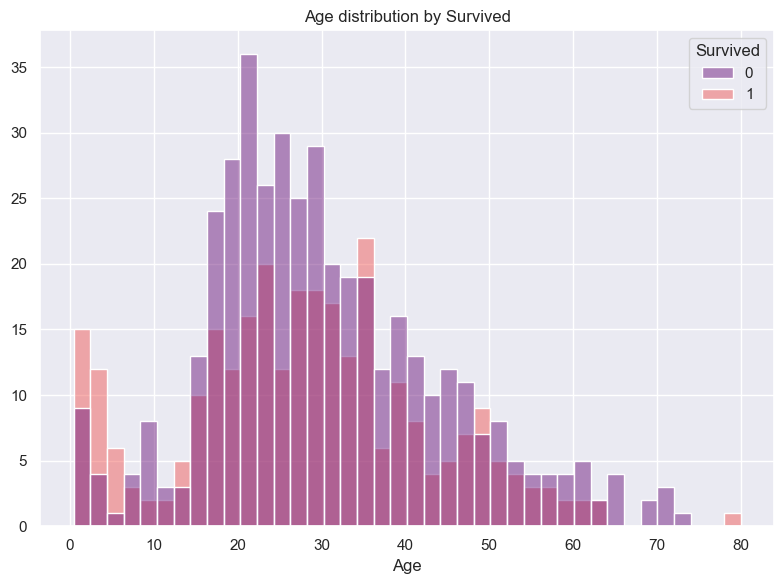

In [29]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df_train, x="Age", bins = 40, hue = "Survived", palette="magma");
plt.title("Age distribution by Survived")
plt.xlabel("Age")
plt.ylabel("")
plt.tight_layout()
plt.show()

**Observation:** <br>
🟢 Majority passengers were from 18 - 50 ages. <br>
🟢 Children had more chance to survive than other ages.

#### 2.2.2. Fare

In [42]:
df_train["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

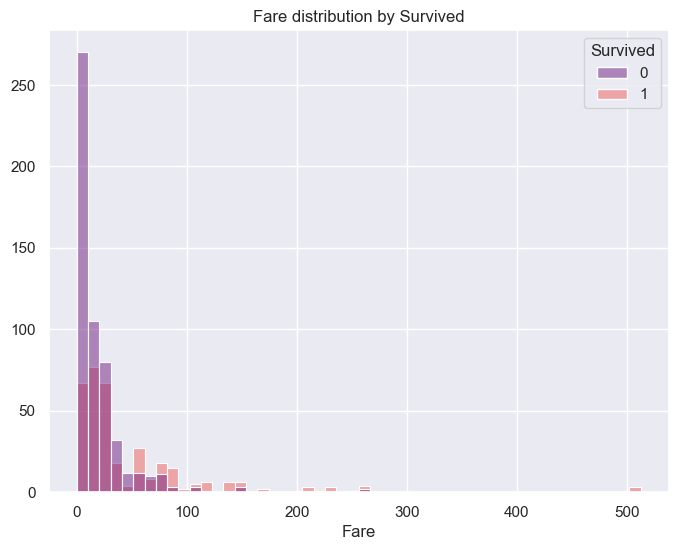

In [50]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df_train, x="Fare", bins = 50, hue = "Survived", palette="magma");
plt.title("Fare distribution by Survived")
plt.xlabel("Fare")
plt.ylabel("")
plt.show()

In [121]:
cal_shapiro(feature_cat="Survived", feature_num="Fare")
cal_Wilcoxon(feature_cat="Survived", feature_num="Fare")

Shapiro-Wilk statistic: 0.513
p - value: 3.233841061826002e-36
⚪ Fare (Survived 0) does not follow normal distribution.
********************************************************************************
Shapiro-Wilk statistic: 0.597
p - value: 1.8337103611620388e-27
⚪ Fare (Survived 1) does not follow normal distribution.
********************************************************************************
Wilcoxon rank-sum test (Mann-Whitney U statistic): 129951.500
p-value: 4.553477179250237e-22
🟢 There is a significant difference between the two groups (not independent)


**Problem** <br>
Based on the visual chart, it will be difficult to see, we can divide it into 4 ranges. <br>
0 - 25%, 25% - 50%, 50% - 75%, 75% - 100% <br>

In [60]:
# To name for 0 - 25%, 25% - 50%, 50% - 75%, 75% - 100%
fare_category = ["Economic", "Standard", "Expensive", "Luxury"]
quartile_data = pd.qcut(df_train["Fare"], 4, labels=fare_category)

quartile_data

PassengerId
1       Economic
2         Luxury
3       Standard
4         Luxury
5       Standard
         ...    
887     Standard
888    Expensive
889    Expensive
890    Expensive
891     Economic
Name: Fare, Length: 891, dtype: category
Categories (4, object): ['Economic' < 'Standard' < 'Expensive' < 'Luxury']

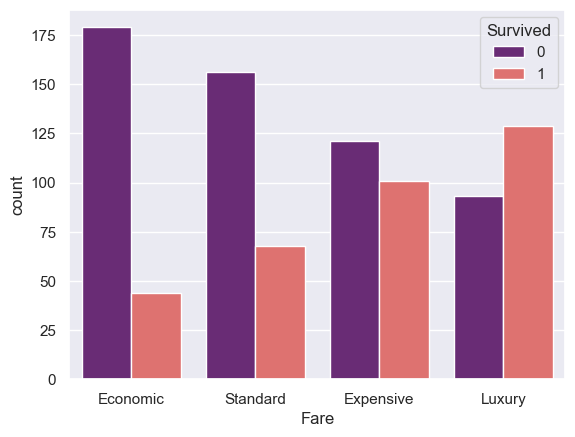

In [61]:
sns.countplot(x=quartile_data, hue=df_train["Survived"], palette="magma");

**Observation:** <br>
* Distribution of fare <br>
🟢 Fare does not allow a normal distribution and has a huge spike at the price range `[0 - 100$]`. <br>
🟢 The distribution is skewed to the left with 75% of the fare paid under `31$` and a max paid fare `$512`. <br>
* Quartile plot <br>
🟢 Passenger with Luxury and Expensive Fare will have more chance to survive.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
## 3. Feature Engineering and data wrangling
### 3.1 Feature Engineering

#### 3.1.1. Family
* `SibSp`, `Parch`

In [62]:
# Merge 2 columns SibSp and Parch.
df_train["Family_Size"] = df_train["SibSp"].astype("int8") + df_train["Parch"].astype("int8") + 1

# (0, 1], (1, 4], (4, 6], (6, 20]
df_train["Family_Cat"] = pd.cut(df_train["Family_Size"], bins = [0, 1, 4, 6, 20], labels= ["Solo", "Small", "Medium", "Large"])

In [63]:
# Merge 2 columns SibSp and Parch.
df_test["Family_Size"] = df_test["SibSp"].astype("int8") + df_test["Parch"].astype("int8") + 1

# (0, 1], (1, 4], (4, 6], (6, 20]
df_test["Family_Cat"] = pd.cut(df_test["Family_Size"], bins = [0, 1, 4, 6, 20], labels= ["Solo", "Small", "Medium", "Large"])

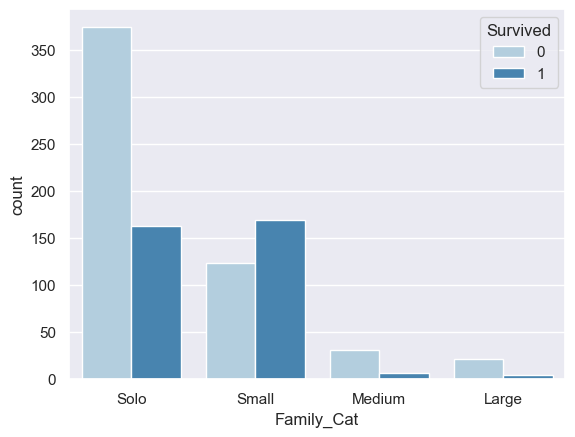

In [64]:
sns.countplot(data=df_train, x = "Family_Cat", hue="Survived", palette="Blues");

**Observation:** <br>
🟢 People who go solo have a very low chance of survival. <br>
🟢 People who go with a small number of companions have a high chance of survival. <br>

#### 3.1.2 Name

In [69]:
import re

def extract_title(name):
    p = re.compile(r",\s*([\w\s]+)\.")
    return p.search(name).groups(1)[0].strip()

df_train["Title"] = df_train["Name"].apply(lambda name: extract_title(name))

In [70]:
df_train["Title"].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

In [71]:
df_test["Title"] = df_test["Name"].apply(lambda name: extract_title(name))
df_test["Title"].value_counts()

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

In [72]:
def group_title(title):
    if title in ["Mr", "Mrs", "Miss", "Master"]:
        return title
    elif title == "Ms":
        return "Miss"
    else:
        return "Others"

df_train["Title"] = df_train["Title"].apply(lambda title: group_title(title))
df_test["Title"] = df_test["Title"].apply(lambda title: group_title(title))

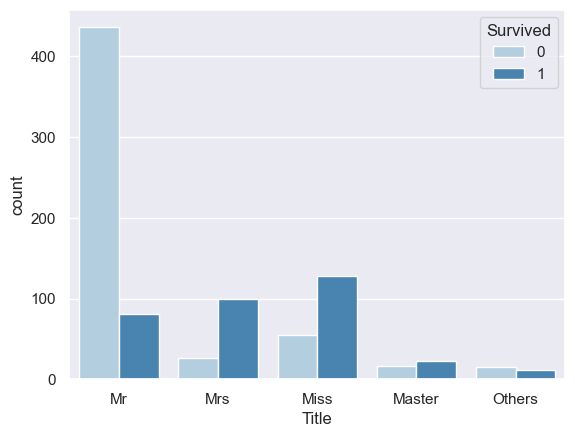

In [73]:
sns.countplot(data=df_train, x="Title", hue = "Survived", palette="Blues");

### 3.2. Data wrangling

In [65]:
num_feature = ["Age", "Fare"]
cat_feature = ["Sex", "Pclass", "Embarked", "Title", "Family_Cat"]
feature_col = num_feature + cat_feature
print(feature_col)

['Age', 'Fare', 'Sex', 'Pclass', 'Embarked', 'Title', 'Family_Cat']


In [74]:
def display_missing(df, feature_col):
    n_rows = df.shape[0]
    for col in feature_col:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"Col {col} has {missing_count}({missing_count * 100 / n_rows:.2f}%) missing value.")
display_missing(df_train, feature_col)
display_missing(df_test, feature_col)

Col Age has 177(19.87%) missing value.
Col Embarked has 2(0.22%) missing value.
Col Age has 86(20.57%) missing value.
Col Fare has 1(0.24%) missing value.


#### 3.2.1. Filling missing value

In [76]:
age_by_sex_pclass = df_train.groupby(["Sex", "Pclass"], observed=True).median(numeric_only = True)["Age"]
age_by_sex_pclass

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

In [77]:
# Filling the missing value in Age with the medians of Sex and Pclass groups.
df_train["Age"] = df_train.groupby(["Sex", "Pclass"], observed=True)["Age"].transform(lambda x: x.fillna(x.median(numeric_only=True)))

In [78]:
df_test["Age"] = df_test.groupby(["Sex", "Pclass"], observed=True)["Age"].transform(lambda x: x.fillna(x.median(numeric_only=True)))

Shapiro-Wilk statistic: 0.940
p - value: 4.79129346482117e-14
⚪ Age (Survived 0) does not follow normal distribution.
********************************************************************************
Shapiro-Wilk statistic: 0.980
p - value: 0.0001169203857520017
⚪ Age (Survived 1) does not follow normal distribution.
********************************************************************************
Wilcoxon rank-sum test (Mann-Whitney U statistic): 89586.500
p-value: 0.24995298582133296
⚪ There is no significant difference between the two groups (independent)


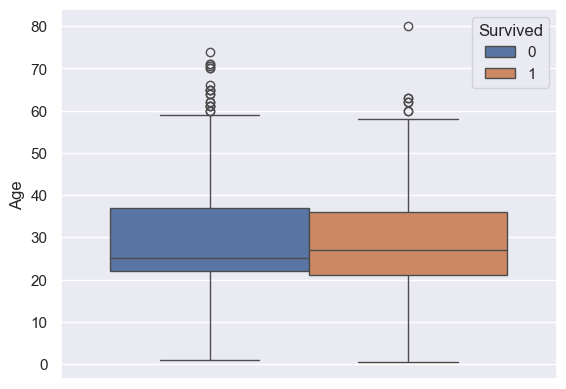

In [119]:
sns.boxplot(data=df_train, y = "Age", hue="Survived");
cal_shapiro(feature_cat="Survived", feature_num="Age")
cal_Wilcoxon(feature_cat="Survived", feature_num="Age")

* There is no significant difference in age between the two groups. In other words, survived does not depend on Age.

In [79]:
display_missing(df_train, feature_col)
display_missing(df_test, feature_col)

Col Embarked has 2(0.22%) missing value.
Col Fare has 1(0.24%) missing value.


In [82]:
X = df_train[feature_col]
y = df_train["Survived"]

In [84]:
X_test = df_test[feature_col]

In [85]:
# Process pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

In [86]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_feature),
        ("cat", cat_transformer, cat_feature),
    ]
)

In [87]:
preprocessor.fit(X)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Pclass', 'Embarked', 'Title',
                                  'Family_Cat'])])

In [88]:
X_prepared = preprocessor.transform(X)

In [89]:
X_test_prepared = preprocessor.transform(X_test)

In [92]:
list_feature_prepared = preprocessor.get_feature_names_out().tolist()
list_feature_prepared

['num__Age',
 'num__Fare',
 'cat__Sex_female',
 'cat__Sex_male',
 'cat__Pclass_1',
 'cat__Pclass_2',
 'cat__Pclass_3',
 'cat__Embarked_C',
 'cat__Embarked_Q',
 'cat__Embarked_S',
 'cat__Title_Master',
 'cat__Title_Miss',
 'cat__Title_Mr',
 'cat__Title_Mrs',
 'cat__Title_Others',
 'cat__Family_Cat_Large',
 'cat__Family_Cat_Medium',
 'cat__Family_Cat_Small',
 'cat__Family_Cat_Solo']

## 4. Model Training

In [96]:
from enum import Enum

class Constants(Enum):
    SEED = 42
    MAX_ITER = 12000
    CV = 5

In [168]:
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV


models = [
    LinearSVC(max_iter=Constants.MAX_ITER.value, random_state=Constants.SEED.value),
    SVC(kernel="rbf", random_state=Constants.SEED.value),
    KNeighborsClassifier(metric = "minkowski", p = 2, n_neighbors=5),
    GaussianNB(),
    LogisticRegression(solver="liblinear", max_iter=Constants.MAX_ITER.value),
    DecisionTreeClassifier(max_depth=5, random_state=Constants.SEED.value),
    RandomForestClassifier(n_estimators=100, random_state=Constants.SEED.value),
    ExtraTreesClassifier(random_state=Constants.SEED.value),
    AdaBoostClassifier(random_state=Constants.SEED.value, algorithm="SAMME"),
    XGBClassifier(eval_metric = "logloss", random_state=Constants.SEED.value),
    MLPClassifier(max_iter=Constants.MAX_ITER.value, random_state=Constants.SEED.value),
    GradientBoostingClassifier(random_state=Constants.SEED.value),
    RidgeClassifier(alpha=1.0, random_state=Constants.SEED.value, max_iter=Constants.MAX_ITER.value),
    RidgeClassifierCV(alphas=[0.1, 0.5, 1.0], cv=Constants.CV.value)
]

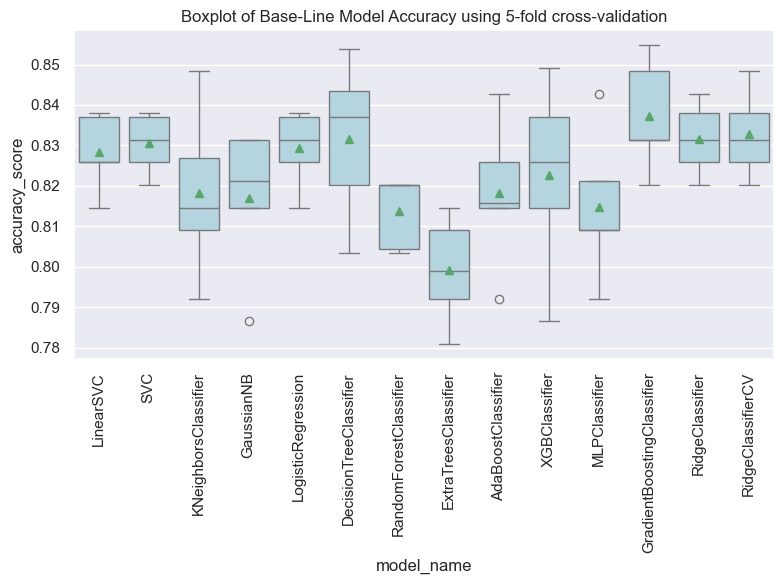

,Mean,Standard Deviation
model_name,,
GradientBoostingClassifier,0.837242,0.014014
RidgeClassifierCV,0.832766,0.010908
RidgeClassifier,0.831643,0.009035
DecisionTreeClassifier,0.831636,0.019990
SVC,0.830519,0.007542
LogisticRegression,0.829396,0.009598
LinearSVC,0.828272,0.009624
XGBClassifier,0.822641,0.023935
AdaBoostClassifier,0.818185,0.018421


In [169]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

def generate_baseline_results(models, X = X_prepared, y = y, metrics = "accuracy", cv = Constants.CV.value, plot_results = False):
    # define K - fold
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=Constants.SEED.value)
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        # print(model_name)
        scores = cross_val_score(model, X, y, scoring = metrics, cv = kfold)
        for fold_idx, score in enumerate(scores):
            entries.append((model_name, fold_idx, score))
    cv_df = pd.DataFrame(entries, columns=["model_name", "fold_id", "accuracy_score"])
    
    if plot_results:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x = "model_name", y = "accuracy_score", data = cv_df, color = "lightblue", showmeans = True)
        plt.title("Boxplot of Base-Line Model Accuracy using 5-fold cross-validation")
        plt.xticks(rotation = 90)
        plt.tight_layout()
        plt.show()
    else:
        pass

    # Summary
    mean = cv_df.groupby("model_name")["accuracy_score"].mean()
    std = cv_df.groupby("model_name")["accuracy_score"].std()

    baseline_result = pd.concat([mean, std], axis=1, ignore_index=True)
    baseline_result.columns = ["Mean", "Standard Deviation"]

    # Sort by accuracy
    baseline_result.sort_values(by=["Mean"], ascending=False, inplace=True)   

    return baseline_result

generate_baseline_results(models, plot_results = True)

* The models GradientBoostingClassifier, RidgeClassifierCV, RidgeClassifier and DecisionTreeClassifier are very promissing.

## 5. Fine-Tune Your Model

### 5.1. GradientBoostingClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=Constants.SEED.value)
model_gradient = GradientBoostingClassifier(random_state=Constants.SEED.value)

param_grid = {
    "n_estimators": [50, 100],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3, 5],
    "subsample": [0.8, 1.0]
}

grid_search_gradient = GridSearchCV(estimator=model_gradient, 
                               param_grid=param_grid,
                               cv=kfold,
                               scoring="accuracy",
                               return_train_score=True,
                               n_jobs=-1)

grid_search_gradient.fit(X_prepared, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5], 'n_estimators': [50, 100],
                         'subsample': [0.8, 1.0]},
             return_train_score=True, scoring='accuracy')

In [146]:
grid_search_gradient.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50,
 'subsample': 1.0}

In [176]:
grid_search_gradient.best_estimator_

GradientBoostingClassifier(max_depth=5, min_samples_split=5, n_estimators=50,
                           random_state=42)

In [147]:
grid_search_gradient.best_score_

np.float64(0.8551942753122841)

### 5.2. RandomForestClassifier

In [ ]:
model_random_forest = RandomForestClassifier(random_state=Constants.SEED.value)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False]
}

grid_search_random_forest = GridSearchCV(estimator=model_random_forest, 
                               param_grid=param_grid,
                               cv=kfold,
                               scoring="accuracy",
                               return_train_score=True,
                               n_jobs=-1)

grid_search_random_forest.fit(X_prepared, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='accuracy')

In [152]:
grid_search_random_forest.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}

In [153]:
grid_search_random_forest.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [154]:
grid_search_random_forest.best_score_

np.float64(0.8406189190885694)

### 5.3. LogisticRegression

In [ ]:
model_logistic = LogisticRegression(max_iter=Constants.MAX_ITER.value)

param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
        'max_iter': [300],
        'fit_intercept': [True],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['saga'],
        'l1_ratio': [0.1, 0.5, 0.9],
        'max_iter': [300],
        'fit_intercept': [True],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['none'],
        'solver': ['lbfgs', 'newton-cg', 'saga'],
        'max_iter': [300],
        'fit_intercept': [True],
        'class_weight': [None, 'balanced']
    }
]

grid_search_logistic = GridSearchCV(estimator=model_logistic, 
                               param_grid=param_grid,
                               cv=kfold,
                               scoring="accuracy",
                               return_train_score=True,
                               n_jobs=-1)

grid_search_logistic.fit(X_prepared, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=12000), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10],
                          'class_weight': [None, 'balanced'],
                          'fit_intercept': [True], 'max_iter': [300],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [0.01, 0.1, 1, 10],
                          'class_weight': [None, 'balanced'],
                          'fit_intercept': [True], 'l1_ratio': [0.1, 0.5, 0.9],
                          'max_iter': [300], 'penalty': ['elasticnet'],
                          'solver': ['saga']},
                         {'class_weight': [None, 'balanced'],
                          'fit_intercept': [True], 'max_iter': [300],
                          'penalty': ['none'],
                          'solver': ['lbfgs', 'newton-cg', 'saga']}],
             return_train_score=True, scoring='accuracy')

In [157]:
grid_search_logistic.best_params_

{'C': 10,
 'class_weight': None,
 'fit_intercept': True,
 'max_iter': 300,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [158]:
grid_search_logistic.best_estimator_

LogisticRegression(C=10, max_iter=300, penalty='l1', solver='liblinear')

In [159]:
grid_search_logistic.best_score_

np.float64(0.8305128366078716)

### 5.4. RidgeClassifierCV

In [ ]:
model_ridge = RidgeClassifier(random_state=Constants.SEED.value)

param_grid = {
    "alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
    "fit_intercept": [True, False],
    "class_weight": [None, "balanced"],
    "solver": ["auto", "sparse_cg", "lsqr"]
}

grid_search_ridge = GridSearchCV(estimator=model_ridge, 
                               param_grid=param_grid,
                               cv=kfold,
                               scoring="accuracy",
                               return_train_score=True,
                               n_jobs=-1)

grid_search_ridge.fit(X_prepared, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RidgeClassifier(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'class_weight': [None, 'balanced'],
                         'fit_intercept': [True, False],
                         'solver': ['auto', 'sparse_cg', 'lsqr']},
             return_train_score=True, scoring='accuracy')

In [165]:
grid_search_ridge.best_params_

{'alpha': 0.01, 'class_weight': None, 'fit_intercept': True, 'solver': 'auto'}

In [166]:
grid_search_ridge.best_estimator_

RidgeClassifier(alpha=0.01, random_state=42)

In [167]:
grid_search_ridge.best_score_

np.float64(0.8327663046889711)

### 5.5. DecisionTreeClassifier

In [ ]:
model_decisiontree = DecisionTreeClassifier(random_state=Constants.SEED.value)

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [3, 5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "class_weight": [None, "balanced"]
}

grid_search_decisiontree = GridSearchCV(estimator=model_decisiontree, 
                               param_grid=param_grid,
                               cv=kfold,
                               scoring="accuracy",
                               return_train_score=True,
                               n_jobs=-1)

grid_search_decisiontree.fit(X_prepared, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 10, 20, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='accuracy')

In [171]:
grid_search_decisiontree.best_params_

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

In [172]:
grid_search_decisiontree.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2,
                       min_samples_split=10, random_state=42)

In [ ]:
grid_search_decisiontree.best_score_

# feature_importances_df = pd.DataFrame({"Feature": list_feature_prepared, "Feature_importance": grid_search_decisiontree.best_estimator_.feature_importances_})
# feature_importances_df.sort_values(by = "Feature_importance", ascending=False)

np.float64(0.8372418555018518)

## 6. Submission

* The mode GradientBoostingClassifier returns "accuracy" score better than other models. So we will use it to predict.

In [ ]:
y_pred = grid_search_gradient.best_estimator_.predict(X_test_prepared)

output = pd.DataFrame({
    "PassengerId": df_test.index,
    "Survived": y_pred
})
output.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
